In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import lineStyles
from back_process import *


# DEFINICION DE INTEGRADOR TEMPORAL
def RK4_FD(eq, fields, parameters, grids, dt, Nt, operators, t_rate): #implementa rouge-kutta
    t_grid = grids[0]
    x_grid = grids[1]
    y_grid = grids[2]
    fields_history = []
    time_grid = []
    for i in range(Nt - 1):
        old_fields = fields
        k_1 = equations_FD(eq, old_fields, t_grid[i], x_grid, y_grid, parameters, operators)
        k_2 = equations_FD(eq, old_fields + 0.5 * dt * k_1, t_grid[i], x_grid, y_grid, parameters, operators)
        k_3 = equations_FD(eq, old_fields + 0.5 * dt * k_2, t_grid[i], x_grid, y_grid, parameters, operators)
        k_4 = equations_FD(eq, old_fields + dt * k_3, t_grid[i], x_grid, y_grid, parameters, operators)
        new_fields = old_fields + dt * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
        fields = new_fields
        if i % t_rate == 0:
            fields_history.append(fields)
            time_grid.append(t_grid[i])
    return fields, fields_history, time_grid

# DEFINICION DE SISTEMA DE ECUACIONES
def equations_FD(eq, field_slices, t_i, x_grid, y_grid, parameters, operators): #ecuaciones
    if eq == "PT_waveguide":
        U = field_slices[0]
        V = field_slices[1]

        k = parameters[0]
        gamma = parameters[1]
        beta = parameters[2]
        delta = parameters[3]

        F = 1j * k * V - 1j * gamma * (U / (1 + np.abs(U) ** 2)) + (beta + 1j * delta) * U
        G = 1j * k * U - 1j * gamma * (V / (1 + np.abs(V) ** 2)) - (beta + 1j * delta) * V

        fields = np.array([F, G])
    return fields

# Define la función f_n
def f_n(z, n, N, k, gamma, delta):
    term1 = (-1) ** n * k * z * ((N + 2)**2 - z**2)
    term2 = -2 * gamma * z * np.sqrt(N**2 - z**2)
    term3 = delta * ((N + 2)**2 - z**2) * np.sqrt(N**2 - z**2)
    return term1 + term2 + term3

def find_roots_vs_N(Ns, k, gamma, delta, dz):
    ROOTS_0 = []
    ROOTS_1 = []

    for N in Ns:
        z_vals = np.arange(-N + dz, N - dz, dz)

        for n, ROOTS in zip([0, 1], [ROOTS_0, ROOTS_1]):
            f_vals = [f_n(z, n, N, k, gamma, delta) for z in z_vals]
            f_vals = np.array(f_vals)

            roots = []
            sign_ref = np.sign(f_vals[0])

            for i in range(1, len(f_vals)):
                sign_now = np.sign(f_vals[i])
                if sign_now != sign_ref and sign_now != 0:
                    z_root = 0.5 * (z_vals[i-1] + z_vals[i])
                    roots.append(z_root)
                    sign_ref = sign_now

            ROOTS.append(roots)

    # Aplanar resultados
    N_vals_0, z_roots_0 = [], []
    N_vals_1, z_roots_1 = [], []

    for i, root_list in enumerate(ROOTS_0):
        for r in root_list:
            N_vals_0.append(Ns[i])
            z_roots_0.append(r)

    for i, root_list in enumerate(ROOTS_1):
        for r in root_list:
            N_vals_1.append(Ns[i])
            z_roots_1.append(r)

    return (np.array(N_vals_0), np.array(z_roots_0),
            np.array(N_vals_1), np.array(z_roots_1))

In [50]:
eq = "PT_waveguide"
t_rate = 1.0

# PARAMETROS (GAMMA = POTENCIAL, K = ACOPLE, ALPHA = GAIN - LOSS)
gamma = 10
k = 1.0
beta = 0.0
delta = 0.0

# PARAMETROS INICIALES (P = CANTIDAD CONSERVADA, X = PORCENTAJE DE INFORMACIÓN INICIAL EN DIMERO 2) ####### Vale pico esto, encuentra los puntos estacionarios como la gente
N = 20.0
theta_0 = 0.0

n = 0
z0 = 0.0 #
z_plus = ((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) + ((2 * gamma * (-1) ** n) / (k)) * (gamma ** 2 / (k ** 2) - 4 * (1 + N)) ** 0.5) ** 0.5
z_minus = ((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) - ((2 * gamma * (-1) ** n) / (k)) * (gamma ** 2 / (k ** 2) - 4 * (1 + N)) ** 0.5) ** 0.5
dz = 0.5
z = np.arange(-N, N, dz) #
phi = np.arange(-np.pi, np.pi, 0.1) #n * np.pi
Nphi = len(phi)
R0 = np.sqrt(N / 2)
R1 = np.sqrt((N - z) / 2)
R2 = np.sqrt((N + z) / 2)

# DEFINICIÓN DE GRILLA TEMPORAL, ESPACIAL SE DEFINE COMO ARRAY CERO POR COMO FUNCIONA EL CODIGO
[tmin, tmax, dt] = [0, 1000, 0.025]
t_grid = np.arange(tmin, tmax + dt, dt)         # TEMPORAL GRID DEFINITION
x_grid = np.array([0])           # SPATIAL GRID DEFINITION
T = tmax
Nt = t_grid.shape[0]

# CONDICIONES INICIALES EN TERMINOS DE P Y X
U_init = []
V_init = []
U_init.append(R1[::1] * np.exp(1j * theta_0))
V_init.append(R2[::1] * np.exp(1j * theta_0))
U_init.append(R1 * np.exp(1j * theta_0))
V_init.append(R2 * np.exp(1j * (theta_0 + np.pi)))
#U_init.append(R0 * np.exp(1j * theta_0 + np.zeros(Nphi)))
#V_init.append(R0 * np.exp(1j * (theta_0 + phi)))

#for i in range(len(phi)):
#    U_init.append(R1 * np.exp(1j * theta_0))
#    V_init.append(R2 * np.exp(1j * (theta_0 + phi[i])))
U_init = np.array([x for arr in U_init for x in arr])
V_init = np.array([x for arr in V_init for x in arr])
# EMPAQUETAMIENTO DE PARAMETROS PARA SIMULACIÓN
operators = [0]
fields_init = [U_init, V_init]
grids = [t_grid, x_grid, 0]
parameters_np = np.array([k, gamma, beta, delta])

# SIMULACIÓN NUMERICA
final_fields, fields_history, time_grid = RK4_FD(eq, fields_init, parameters_np, grids, dt, Nt, operators, t_rate)      #NUMERICAL SIMULATION

# REOBTENIENDO DATOS DE SIMULACIÓN
U = np.array(fields_history)[:, 0]
V = np.array(fields_history)[:, 1]
lightness = 1
U_light = U[0::lightness]
V_light = V[0::lightness]
t_light = np.array(time_grid[0::lightness])
P1 = np.abs(U_light) ** 2
P2 = np.abs(V_light) ** 2

N_variable = P1 + P2
z_variable = P2 - P1
arg_variable = np.angle(U_light * np.conjugate(V_light))

In [51]:
n = 0
z_pp_0 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) + ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mm_0 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) - ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_pm_0 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) - ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mp_0 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) + ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5

n = 1
z_pp_1 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) + ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mm_1 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) - ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_pm_1 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) - ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mp_1 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k**2) + ((2 * gamma) / (k ** 2)) * (gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5

In [52]:
Ns = np.arange(0.2, 30, 0.1)
k, gamma, delta, dz = 1.0, 10.0, 0.00, 0.05
N_vals_0a, z_roots_0a, N_vals_1a, z_roots_1a = find_roots_vs_N(Ns, k, gamma, delta, dz)

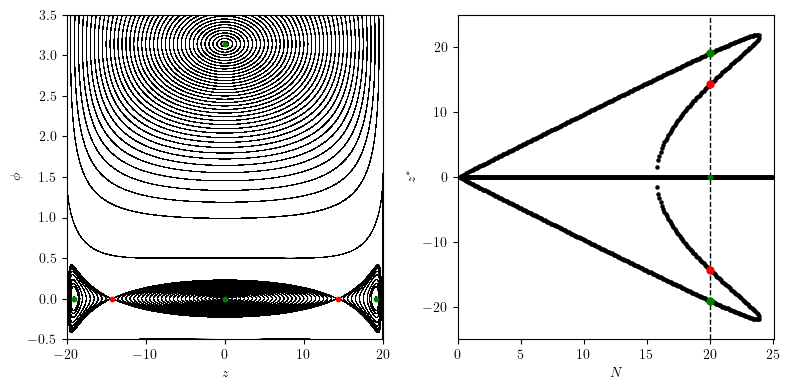

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].scatter(0, 0, zorder=5, color="g", s=10)
ax[0].scatter(0, np.pi, zorder=5, color="g", s=10)
ax[0].scatter(z_mp_0, 0, zorder=5, color="g", s=10)
ax[0].scatter(z_pp_0, 0, zorder=5, color="g", s=10)
ax[0].scatter(z_pm_0, 0, zorder=5, color="r", s=10)
ax[0].scatter(z_mm_0, 0, zorder=5, color="r", s=10)

ax[0].plot(z_variable[::], np.unwrap(arg_variable, axis=0)[::], color="k", lw=0.2)
ax[0].set_xlim([-N, N])
ax[0].set_ylim([-0.5, 3.5])
ax[0].set_xlabel('$z$')
ax[0].set_ylabel(r'$\phi$')

ax[1].scatter(N_vals_0a, z_roots_0a, s=5, color='k')
ax[1].scatter(N_vals_1a, z_roots_1a, s=5, color='k')
ax[1].scatter(N, 0, zorder=5, color="g", s=10)
ax[1].scatter(N, z_mp_0, zorder=5, color="g", s=25)
ax[1].scatter(N, z_pp_0, zorder=5, color="g", s=25)
ax[1].scatter(N, z_pm_0, zorder=5, color="r", s=25)
ax[1].scatter(N, z_mm_0, zorder=5, color="r", s=25)
ax[1].vlines(20, -25, 25, zorder=0, color="k", ls="--", lw=1.0)
ax[1].set_xlim([0, 25.1])
ax[1].set_ylim([-25, 25])
ax[1].set_xlabel('$N$')
ax[1].set_ylabel('$z^{*}$')

plt.tight_layout()
plt.savefig(r"C:\Users\Rafa\PycharmProjects\LENL_simulations\00_projects\PT_waveguides\simulations\traditional_a.png", dpi=300)

In [64]:
z_stable = np.array([0, 0, z_pp_0, -z_pp_0, z_pm_0])
phi_stable = np.array([0, np.pi, 0, 0, 0.01])
R1_stable = np.sqrt((N - z_stable) / 2)
R2_stable = np.sqrt((N + z_stable) / 2)

U_stable_init = []
V_stable_init = []
# CONDICIONES INICIALES EN TERMINOS DE P Y X
for i in range(len(z_stable)):
    U_stable_init.append(R1_stable[i] * np.exp(1j * theta_0))
    V_stable_init.append(R2_stable[i] * np.exp(1j * (theta_0 + phi_stable[i])))
U_stable_init = np.array(U_stable_init, dtype="complex")
V_stable_init = np.array(V_stable_init, dtype="complex")
fields_stable_init = [U_stable_init, V_stable_init]

final_fields_stable, fields_history_stable, time_grid_stable = RK4_FD(eq, fields_stable_init, parameters_np, grids, dt, Nt, operators, t_rate)      #NUMERICAL SIMULATION

# REOBTENIENDO DATOS DE SIMULACIÓN
U_stable = np.array(fields_history_stable)[:, 0]
V_stable = np.array(fields_history_stable)[:, 1]
lightness = 1
U_stable_light = U_stable[0::lightness]
V_stable_light = V_stable[0::lightness]
t_light = np.array(time_grid[0::lightness])
P1_stable = np.abs(U_stable_light) ** 2
P2_stable = np.abs(V_stable_light) ** 2

N_variable_stable = P1_stable + P2_stable
z_variable_stable = P2_stable - P1_stable
arg_variable_stable = np.angle(U_stable_light * np.conjugate(V_stable_light))

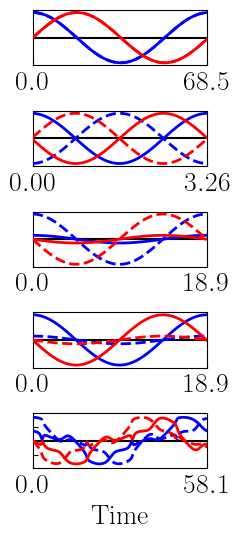

In [72]:
fig, ax = plt.subplots(5, 1, figsize=(2.5, 5.5), dpi=100)
for i in range(len(U_stable_light[0, :])):
    ax[i].plot(t_light, np.real(U_stable_light[:, i]), color="b", zorder=5, lw=2)
    ax[i].plot(t_light, np.real(V_stable_light[:, i]), color="b", ls="--", zorder=5, lw=2)
    ax[i].plot(t_light, np.imag(U_stable_light[:, i]), color="r", zorder=5, lw=2)
    ax[i].plot(t_light, np.imag(V_stable_light[:, i]), color="r", ls="--", zorder=5, lw=2)
ax[0].set_xlim(0, 68.5)
ax[1].set_xlim(0, 3.26)
ax[2].set_xlim(0, 18.9)
ax[3].set_xlim(0, 18.9)
ax[4].set_xlim(0, 58.1)

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

ax[0].hlines(0, 0, 100, color="k", zorder=0)
ax[1].hlines(0, 0, 10, color="k", zorder=0)
ax[2].hlines(0, 0, 50, color="k", zorder=0)
ax[3].hlines(0, 0, 100, color="k", zorder=0)
ax[4].hlines(0, 0, 100, color="k", zorder=0)

ax[0].tick_params(axis="x", direction="in", labelsize=20)
ax[0].tick_params(axis="y", direction="in", labelleft=False)
ax[0].set_xticks([0, 68.5])

ax[1].tick_params(axis="x", direction="in", labelsize=20)
ax[1].tick_params(axis="y", direction="in", labelleft=False)
ax[1].set_xticks([0, 3.26])

ax[2].tick_params(axis="x", direction="in", labelsize=20)
ax[2].tick_params(axis="y", direction="in", labelleft=False)
ax[2].set_xticks([0, 18.9])

ax[3].tick_params(axis="x", direction="in", labelsize=20)
ax[3].tick_params(axis="y", direction="in", labelleft=False)
ax[3].set_xticks([0, 18.9])

ax[4].tick_params(axis="x", direction="in", labelsize=20)
ax[4].tick_params(axis="y", direction="in", labelleft=False)
ax[4].set_xticks([0, 58.1])
ax[4].set_xlabel("\\textrm{Time}", fontsize=20)


plt.tight_layout()
plt.savefig(r"C:\Users\Rafa\PycharmProjects\LENL_simulations\00_projects\PT_waveguides\simulations\traditional_b.png", dpi=300)